In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
import tqdm
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16


/home/lex/workflow/venv/advanced-dl/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [3]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [4]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

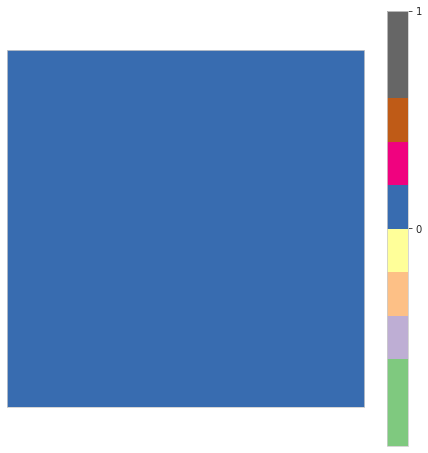

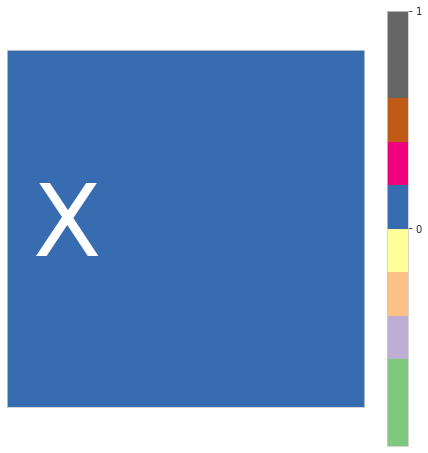

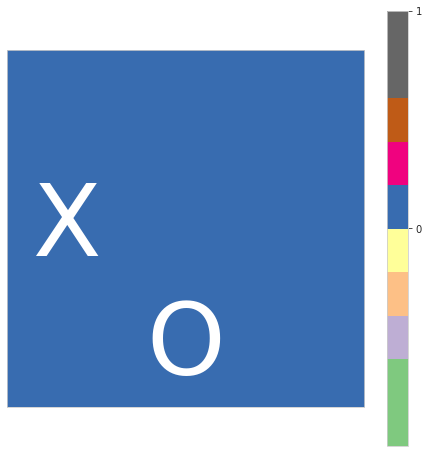

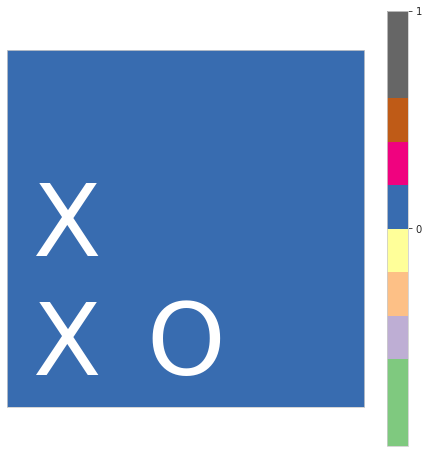

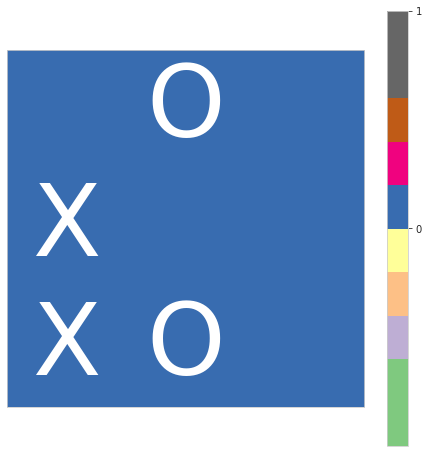

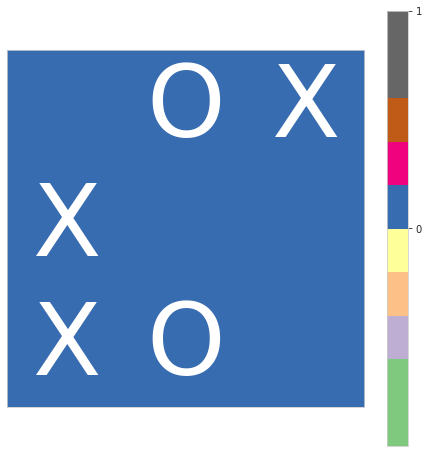

Нолики выиграли!


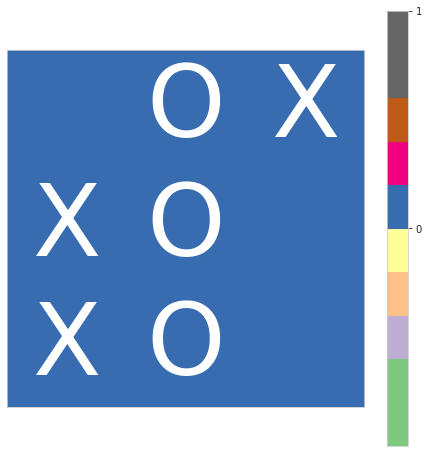

In [5]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=100)

### Часть первая: крестики-нолики при помощи Q-обучения


Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [6]:
def Q_learning(env, pi_1, pi_2, alpha=0.01, epsilon=0.1, gamma=1.0):
    done = False
    env.reset()
    board_hash, empty_spaces, cur_turn = env.getState()
    reward = 0
    cur_state = board_hash, empty_spaces, cur_turn

    previous_state = None, None, None
    previous_board_hash, previous_action, previous_turn = previous_state


    while not done:
        # Меняем местами крестики\нолики в зависимости от хода для удобства
        pi1, pi2 = (pi_1, pi_2) if cur_turn == 1 else (pi_2, pi_1)

        action_index = pi1.get_action_epsilon(board_hash, len(empty_spaces), epsilon)
        action = empty_spaces[action_index]

        cur_state = board_hash, action_index, cur_turn
        state, reward, done, _ = env.step(action)
        board_hash, empty_spaces, cur_turn = state

        # Обновляем для текущего хода
        if previous_board_hash is not None:
            gamma_term = gamma * np.max(pi2.Q[board_hash]) if board_hash in pi2.Q else 0
            pi2.Q[previous_board_hash][previous_action] = pi2.Q[previous_board_hash][previous_action] + alpha * (
                cur_turn * reward + gamma_term - pi2.Q[previous_board_hash][previous_action])
            
        # Меняем предыдущее состояние
        previous_board_hash, previous_action, previous_turn = cur_state

        # Обновляем при победе
        if reward * previous_turn == 1:
              pi1.Q[previous_board_hash][action_index] = previous_turn * reward
        
        pi_1, pi_2 = (pi1, pi2) if previous_turn == 1 else (pi2, pi1)

In [7]:
class Policy:
    def __init__(self):
        self.Q = dict()
    def getActionGreedy(self, s, len_a):
        if s in self.Q:
            return np.argmax(self.Q[s])
        else:
            return np.random.randint(len_a)

    def get_action_epsilon(self, s, len_a, epsilon):
        if s in self.Q and np.random.random() > epsilon:
            action = np.argmax(self.Q[s])
        else:
            action = np.random.randint(len_a)
            if s not in self.Q:
                self.Q[s] = np.zeros(len_a)
        return action

In [8]:
def play_test_game(env, pi_1=None, pi_2=None):
    env.reset()
    done = False
    board_hash, empty_spaces, cur_turn = env.getState()
    while not done:
        pi = pi_1 if cur_turn == 1 else pi_2
        if pi is not None and board_hash in pi.Q:
            action_index = np.argmax(pi.Q[board_hash])
        else:
            action_index = np.random.randint(len(empty_spaces))
    
        action = empty_spaces[action_index]
        state, reward, done, _ = env.step(action)
        board_hash, empty_spaces, cur_turn = state
        
    return reward

def evaluate_policy(env, pi_1=None, pi_2=None, num_episodes=500):
    reward = 0
    for _ in range(num_episodes):
        reward += play_test_game(env, pi_1=pi_1, pi_2=pi_2)
    return reward / num_episodes

Для 3х3, против случайных агентов

In [9]:
pi_1_3 = Policy()
pi_2_3 = Policy()

env = TicTacToe(3, 3, 3)
total_episodes = 100000
index = []
crosses = []
noughts = []

for i in tqdm.tqdm(range(1, total_episodes + 1)):
    Q_learning(env, pi_1_3, pi_2_3, epsilon=0.3)
    if i % 1000 == 0:
        cross = evaluate_policy(env, pi_1=pi_1_3, pi_2=None)
        nought = -evaluate_policy(env, pi_1=None, pi_2=pi_2_3)
        index.append(i)
        crosses.append(cross)
        noughts.append(nought)
index = np.array(index)
crosses = np.array(crosses)
noughts = np.array(noughts)


100%|██████████| 100000/100000 [01:24<00:00, 1186.33it/s]


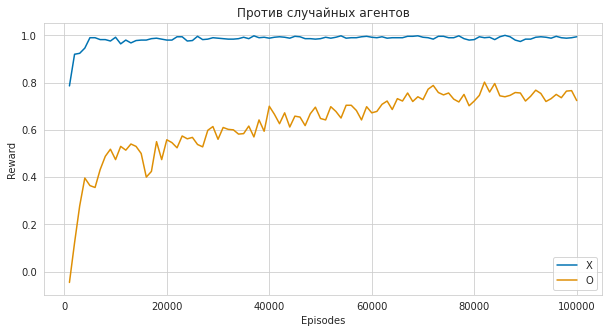

In [10]:
plt.figure(figsize=(10, 5))
plt.title('Против случайных агентов')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(index, crosses, label='X')
plt.plot(index, noughts, label='O')
plt.legend(loc="lower right")

До этого агенты играли против случайных стратегий, посмотрим что против друг друга

100%|██████████| 10000/10000 [00:02<00:00, 3632.37it/s]


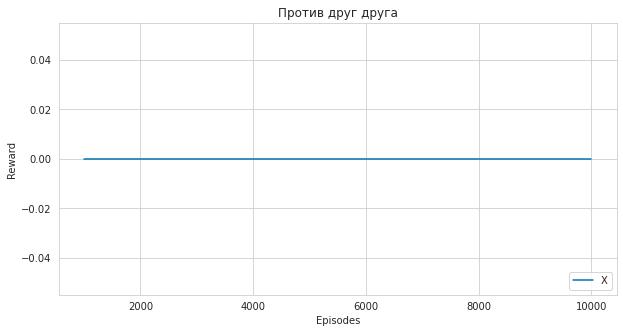

In [11]:
index = []
crosses = []
for i in tqdm.tqdm(range(1, 10000 + 1)):
    if i % 1000 == 0:
        cross = evaluate_policy(env, pi_1=pi_1_3, pi_2=pi_2_3)
        index.append(i)
        crosses.append(cross)
index = np.array(index)
crosses = np.array(crosses)
plt.figure(figsize=(10, 5))
plt.title('Против друг друга')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(index, crosses, label='X')
plt.legend(loc="lower right")

Как и следовало ожидать выходит ничья

Для 4x4 уже начинает считаться долго, поэтому ограничился 500000 эпизодами

In [12]:
pi_1_4 = Policy()
pi_2_4 = Policy()

env = TicTacToe(4, 4, 4)
total_episodes = 500000
index = []
crosses = []
noughts = []

for i in tqdm.tqdm(range(1, total_episodes + 1)):
    Q_learning(env, pi_1_4, pi_2_4, epsilon=0.3)
    if i % 2000 == 0:
        cross = evaluate_policy(env, pi_1=pi_1_4, pi_2=None)
        nought = -evaluate_policy(env, pi_1=None, pi_2=pi_2_4)
        index.append(i)
        crosses.append(cross)
        noughts.append(nought)
index = np.array(index)
crosses = np.array(crosses)
noughts = np.array(noughts)


100%|██████████| 500000/500000 [13:50<00:00, 602.25it/s]


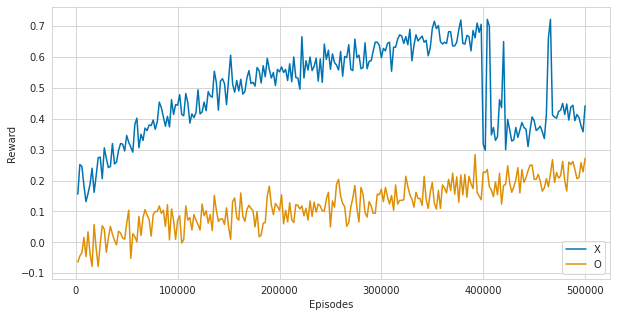

In [13]:
plt.figure(figsize=(10, 5))
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(index, crosses, label='X')
plt.plot(index, noughts, label='O')
plt.legend(loc="lower right")

### Часть вторая: добавим нейронных сетей

Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.


In [14]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [15]:
class Network_3(nn.Module):
    def __init__(self, layer_size=128):
        nn.Module.__init__(self)
        self.c1 = nn.Conv2d(3, layer_size * 2, (3, 3))
        self.l1 = nn.Linear(layer_size * 2, layer_size)
        self.l2 = nn.Linear(layer_size, 9)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [16]:
# 1 - X
#-1 - O
class TicTacToeDQN():
    def __init__(self, model, n_rows=3, n_wins=3):
        self.n_rows = n_rows
        self.env = TicTacToe(n_rows, n_rows, n_wins)
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
        self.model = {1: model().to(self.device), -1: model().to(self.device)}
        self.memory = {1: ReplayMemory(100000), -1: ReplayMemory(100000)}
        
        self.optimizer = {1: optim.Adam(self.model[1].parameters(), 0.001), -1: optim.Adam(self.model[-1].parameters(), 0.001)}
        self.steps_done = 0
        self.episode_durations = []
        self.previous_states = {-1: None, 1: None}
        self.previous_actions = {}
        self.gamma = 0.8
        self.batch_size = 512
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 100000
        self.num_step = 0

    def select_greedy_action(self, state, cur_turn):
        return self.model[cur_turn](state.unsqueeze(0)).data.max(1)[1].view(1, 1)

    def select_action(self, state, cur_turn):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state, cur_turn)
        else:
            return torch.tensor([[random.randrange(self.n_rows * self.n_rows)]], dtype=torch.int64)

    def to_tensor(self, s):
        s = np.array([int(c) for c in s])
        size = int(np.sqrt(len(s)))
        crosses = np.where(s==2, 1, 0).reshape(size, size)
        noughts = np.where(s==0, 1, 0).reshape(size, size)
        empty_spaces = np.where(s==1, 1, 0).reshape(size, size)
        return torch.Tensor(np.stack([crosses, noughts, empty_spaces])).reshape(3, size, size)

    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        self.env.reset()
        state, _, cur_turn = self.env.getState()
        while True:
            state_tensor = self.to_tensor(state)
            with torch.no_grad():
                if greedy:
                    action_idx = self.select_greedy_action(state_tensor.to(self.device), cur_turn).cpu()
                else:
                    action_idx = self.select_action(state_tensor.to(self.device), cur_turn).cpu()

            self.previous_states[cur_turn] = state_tensor
            self.previous_actions[cur_turn] = action_idx
            action = self.env.action_from_int(action_idx.numpy()[0][0])
            (next_state, empty_spaces, cur_turn), reward, done, _ = self.env.step(action)
            next_state_tensor = self.to_tensor(next_state)
            if reward == -10:
                transition = (state_tensor, action_idx, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
                self.memory[cur_turn].store(transition)
                
            else:
                if self.previous_states[cur_turn] is not None:
                    if reward == -cur_turn:
                        transition = (self.previous_states[-cur_turn], 
                                      self.previous_actions[-cur_turn], 
                                      next_state_tensor, 
                                      torch.tensor([1.0], dtype=torch.float32)
                                     )
                        self.memory[-cur_turn].store(transition)
                    transition = (self.previous_states[cur_turn], 
                                  self.previous_actions[cur_turn], 
                                  next_state_tensor, 
                                  torch.tensor([reward * cur_turn], dtype=torch.float32)
                                 )
                    self.memory[cur_turn].store(transition)

            
            if do_learning:
                self.learn(cur_turn)

            state = next_state

            if done:
                break


    def learn(self, cur_turn):
        if np.min([len(self.memory[cur_turn]), len(self.memory[-cur_turn])]) < self.batch_size:
            return
        
        # берём мини-батч из памяти
        transitions = self.memory[cur_turn].sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.stack(batch_state).to(self.device))
        batch_action = Variable(torch.cat(batch_action).to(self.device))
        batch_reward = Variable(torch.cat(batch_reward).to(self.device))
        batch_next_state = Variable(torch.stack(batch_next_state).to(self.device))
        
        # считаем значения функции Q
        Q = self.model[cur_turn](batch_state)
        Q = Q.gather(1, batch_action).reshape([self.batch_size])
        
        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model[cur_turn](batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)
    
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer[cur_turn].zero_grad()
        loss.backward()
        self.optimizer[cur_turn].step()

In [17]:
def play_test_game(dqn, player):
    dqn.env.reset()
    state, empty_spaces, cur_turn = dqn.env.getState()
    done = False
    while not done:
        if cur_turn == player:
            idx = dqn.select_greedy_action(dqn.to_tensor(state).to(dqn.device), player)
            action = dqn.env.action_from_int(idx)
        else:
            idx = np.random.randint(len(empty_spaces))
            action = empty_spaces[idx]
        (state, empty_spaces, cur_turn), reward, done, _ = dqn.env.step(action)
    
    if reward == player:
        return reward * player
    else:
        return 0

def evaluate_policy(dqn, player, num_episodes=1000):
    reward = 0
    # Skip failed
    num_episodes_ = num_episodes
    for _ in range(num_episodes):
        rew = play_test_game(dqn, player)
        reward += rew
    return reward / num_episodes_

In [18]:
dqn_3 = TicTacToeDQN(Network_3, 3, 3)
total_episodes = 10000
crosses = []
noughts = []
index = []
for i in tqdm.tqdm(range(1, total_episodes + 1)):
    dqn_3.run_episode()
    if i % 1000 == 0:
        index.append(i)
        cross = evaluate_policy(dqn_3, 1)
        nought = evaluate_policy(dqn_3, -1)
        crosses.append(cross)
        noughts.append(nought)

100%|██████████| 10000/10000 [05:10<00:00, 32.16it/s]


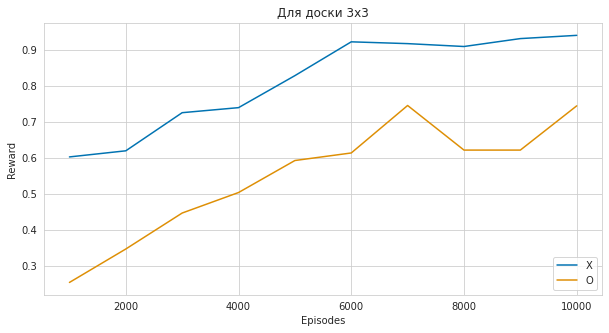

In [19]:
plt.figure(figsize=(10, 5))
plt.title('Для доски 3х3')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(index, crosses, label='X')
plt.plot(index, noughts, label='O')
plt.legend(loc="lower right")

In [20]:
class Network_4(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.c1 = nn.Conv2d(3, 16, (3, 3))
        self.c2 = nn.Conv2d(16, 256, (2, 2))
        self.l1 = nn.Linear(256, 128)
        self.l2 = nn.Linear(128, 16)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [21]:
dqn_4 = TicTacToeDQN(Network_4, 4, 4)
total_episodes = 10000
crosses = []
noughts = []
index = []
for i in tqdm.tqdm(range(1, total_episodes + 1)):
    dqn_4.run_episode()
    if i % 1000 == 0:
        index.append(i)
        cross = evaluate_policy(dqn_4, 1)
        nought = evaluate_policy(dqn_4, -1)
        crosses.append(cross)
        noughts.append(nought)

100%|██████████| 10000/10000 [08:07<00:00, 20.50it/s] 


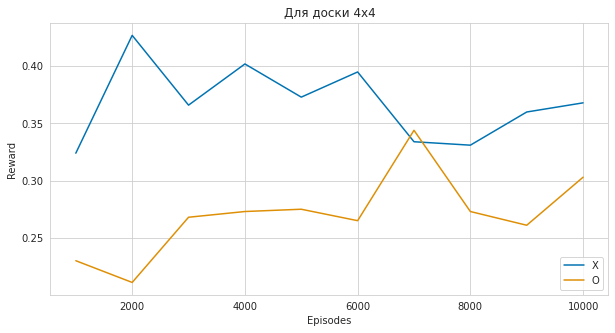

In [22]:
plt.figure(figsize=(10, 5))
plt.title('Для доски 4х4')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(index, crosses, label='X')
plt.plot(index, noughts, label='O')
plt.legend(loc="lower right")

Если пообучаться дольше, то результаты улучшатся

Реализуйте Double DQN и/или Dueling DQN.

In [25]:
class DoubleDQN(TicTacToeDQN):
    def __init__(self, model, n_rows, n_wins):
        super().__init__(n_rows=n_rows, n_wins=n_wins, model=model)
        self.target_model = {-1: model().to(self.device), 1: model().to(self.device)}
        self.episodes_learned = {-1: 0, 1: 0}

    def learn(self, cur_turn):
        if np.min([len(self.memory[cur_turn]), len(self.memory[-cur_turn])]) < self.batch_size:
            return
        
        # берём мини-батч из памяти
        transitions = self.memory[cur_turn].sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.stack(batch_state).to(self.device))
        batch_action = Variable(torch.cat(batch_action).to(self.device))
        batch_reward = Variable(torch.cat(batch_reward).to(self.device))
        batch_next_state = Variable(torch.stack(batch_next_state).to(self.device))
        
        # считаем значения функции Q
        Q = self.model[cur_turn](batch_state)
        Q = Q.gather(1, batch_action).reshape([self.batch_size])
        
        # оцениваем ожидаемые значения после этого действия
        Qmax = self.target_model[cur_turn](batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)
        self.optimizer[cur_turn].zero_grad()
        loss.backward()
        
        self.optimizer[cur_turn].step()
        
        self.episodes_learned[cur_turn] += 1
        if self.episodes_learned[cur_turn] % 500:
            self.target_model[cur_turn].load_state_dict(self.model[cur_turn].state_dict())

100%|██████████| 10000/10000 [05:10<00:00, 32.26it/s]


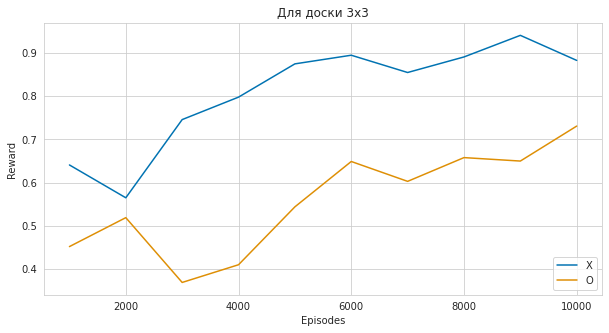

In [27]:
dqn_3 = DoubleDQN(Network_3, 3, 3)
total_episodes = 10000
crosses = []
noughts = []
index = []
for i in tqdm.tqdm(range(1, total_episodes + 1)):
    dqn_3.run_episode()
    if i % 1000 == 0:
        index.append(i)
        cross = evaluate_policy(dqn_3, 1)
        nought = evaluate_policy(dqn_3, -1)
        crosses.append(cross)
        noughts.append(nought)
plt.figure(figsize=(10, 5))
plt.title('Для доски 3х3')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(index, crosses, label='X')
plt.plot(index, noughts, label='O')
plt.legend(loc="lower right")

In [ ]:
dqn = DoubleDQN(Network_4, 4, 4)
total_episodes = 10000
crosses = []
noughts = []
index = []
for i in tqdm.tqdm(range(1, total_episodes + 1)):
    dqn.run_episode()
    if i % 1000 == 0:
        index.append(i)
        cross = evaluate_policy(dqn, 1)
        nought = evaluate_policy(dqn, -1)
        crosses.append(cross)
        noughts.append(nought)
plt.figure(figsize=(10, 5))
plt.title('Для доски 4х4')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(index, crosses, label='X')
plt.plot(index, noughts, label='O')
plt.legend(loc="lower right")

 95%|█████████▌| 9525/10000 [08:04<00:19, 23.96it/s]  